In [19]:
import numpy as np
import pandas as pd
import neurokit2 as nk
from scipy import signal
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [20]:
# 读取数据
data_path = "./data/processed_data/ecg_signals.pkl"
df = pd.read_pickle(data_path)

In [21]:
sampling_rate = 500  # 采样率

In [22]:
df.head()

,file,start_idx,end_idx,signal_quality,ecg_segment
0,20250521001_2025-05-21 18_45_58_b.csv,0,5000,0.0,"[-517.0, -523.0, -529.0, -535.0, -538.0, -538...."
1,20250521001_2025-05-21 18_45_58_b.csv,4000,9000,0.0,"[-801.0, -800.0, -798.0, -800.0, -799.0, -811...."
2,20250521001_2025-05-21 18_45_58_b.csv,8000,13000,0.0,"[-1014.0, -1009.0, -1003.0, -1003.0, -1011.0, ..."
3,20250521001_2025-05-21 18_48_11_b.csv,0,5000,0.0,"[-611.0, -608.0, -605.0, -608.0, -604.0, -600...."
4,20250521001_2025-05-21 18_48_11_b.csv,4000,9000,0.0,"[-674.0, -673.0, -679.0, -675.0, -675.0, -678...."


In [23]:
df["signal_quality"].unique()  # 查看信号质量标签

array([0. , 1. , 0.5])

In [24]:
# 删除信号质量为 0.5 的标签
df = df[df["signal_quality"] != 0.5].reset_index(drop=True)
print(df.shape[0])

5782


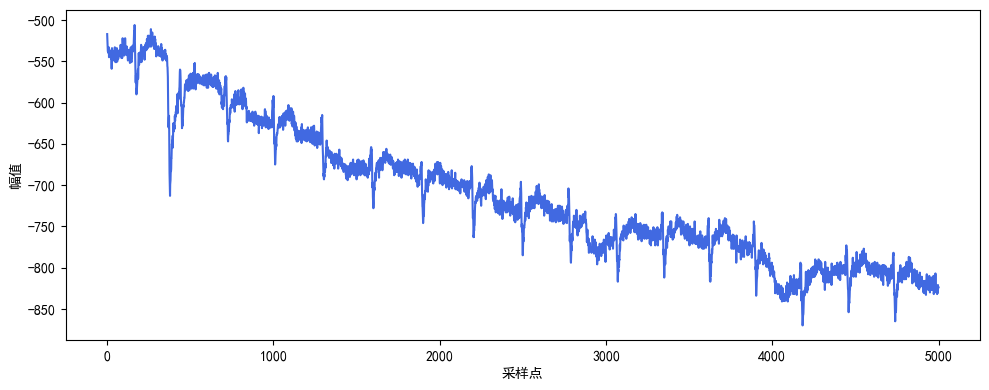

In [25]:
# 画出一段 ecg 信号
ecg = df.iloc[0]["ecg_segment"]

plt.figure(figsize=(10, 4))
plt.plot(ecg, color="royalblue")
plt.xlabel("采样点")
plt.ylabel("幅值")
plt.tight_layout()
plt.show()

In [26]:
# ecg 去噪

import pywt
from scipy.signal import butter, filtfilt


def adb_2_ecg(adb):
    """将adb信号转换为ECG信号。

    Args:
        adb (np.ndarray): 原始adb信号

    Returns:
        np.ndarray: 转换后的ECG信号
    """
    VREF = 2.42
    G = 6
    ecg = adb * 1000 * VREF / (32767 * G)
    return ecg


def highpass_filter(sig, fs=500, cutoff=5, order=4):
    """高通滤波器，去除低频干扰。

    Args:
        sig (np.ndarray): 输入信号
        fs (int): 采样率，默认500Hz
        cutoff (float): 截止频率，默认5Hz
        order (int): 滤波器阶数，默认4

    Returns:
        np.ndarray: 滤波后的信号
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype="high")
    filtered_sig = filtfilt(b, a, sig)
    return filtered_sig


def wt_filter(sig, wavelet="db4", threshold=0.1):
    """小波去噪

    Args:
        sig (np.ndarray): 输入信号
        wavelet (str, optional): 小波基，默认"db4"
        threshold (float, optional): 阈值，默认0.1

    Returns:
        np.ndarray: 去噪后的信号
    """
    coeffs = pywt.wavedec(sig, wavelet)
    coeffs_thresholded = [pywt.threshold(c, threshold, mode="soft") for c in coeffs]
    return pywt.waverec(coeffs_thresholded, wavelet)

df['normalized_ecg'] = df["ecg_segment"].apply(lambda x: adb_2_ecg(x))
df['denoised_ecg'] = df['normalized_ecg'].apply(lambda x: wt_filter(highpass_filter(x, fs=sampling_rate), wavelet="db4", threshold=0.1))

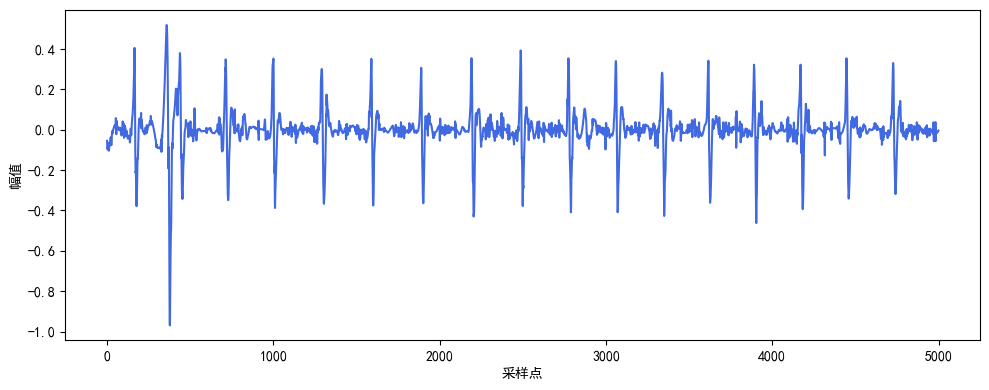

In [27]:
# 画出一段去噪后的 ecg 信号
denoised_ecg = df.iloc[0]["denoised_ecg"]

plt.figure(figsize=(10, 4))
plt.plot(denoised_ecg, color="royalblue")
plt.xlabel("采样点")
plt.ylabel("幅值")
plt.tight_layout()
plt.show()

In [28]:
def calc_skewness(sig: np.array) -> float:
    """
    计算信号的偏度（Skewness）。

    Args:
        sig (np.ndarray): 输入信号

    Returns:
        float: 偏度指标，反映信号分布的非对称性
    """
    num = np.mean((sig - np.mean(sig)) ** 3)
    skewness = num / (np.std(sig, ddof=1) ** 3)
    skewness_score = float(round(skewness, 3))
    return skewness_score


def calc_kurtosis(sig: np.array) -> float:
    """
    计算信号的峰度（Kurtosis）。

    Args:
        sig (np.ndarray): 输入信号

    Returns:
        float: 峰度指标，反映信号分布的尖锐程度（已减去正态分布的3）
    """
    num = np.mean((sig - np.mean(sig)) ** 4)
    kurtosis = num / (np.std(sig, ddof=1) ** 4)
    kurtosis_fischer = kurtosis - 3.0
    kurtosis_score = float(round(kurtosis_fischer, 3))
    return kurtosis_score

df["skewness"] = df["denoised_ecg"].apply(calc_skewness)
df["kurtosis"] = df["denoised_ecg"].apply(calc_kurtosis)

In [29]:
# 参考方法（neurokit2）：
# QRS complexes are detected based on the steepness of the absolute gradient of the ECG signal.
# R-peaks are detected as local maxima in QRS complexes.
# 相关讨论与算法详见：
#   https://github.com/neuropsychology/NeuroKit/issues/476
#   https://doi.org/10.21105/joss.02621


def normalize_data(sig):
    sig = np.array(sig)
    min_val = np.min(sig)
    max_val = np.max(sig)
    if max_val - min_val == 0:
        return np.zeros_like(sig)
    return (sig - min_val) / (max_val - min_val)


def ecg_find_peaks(ecg_cleaned, sampling_rate=500):
    """
    对ECG信号进行去噪后检测R波峰值

    Args:
        ecg (np.ndarray): 输入ECG信号
        sampling_rate (int): 采样率，默认500Hz

    Returns:
        peaks (np.ndarray): R波峰索引
    """
    signals, info = nk.ecg_peaks(
        ecg_cleaned, sampling_rate=sampling_rate, method="neurokit"
    )
    peaks = info["ECG_R_Peaks"]
    return peaks


def _ecg_heart_cycle_detection(ecg, sampling_rate):
    """
    检测ECG信号的心动周期（每个心跳波形片段）。

    Args:
        ecg (np.ndarray): 输入ECG信号
        sampling_rate (int): 采样率

    Returns:
        list: 每个心动周期的波形片段
    """
    ecg_normalized = normalize_data(ecg)
    upsampled_len = len(ecg_normalized) * 2
    ecg_upsampled = signal.resample(ecg_normalized, upsampled_len)
    peaks = ecg_find_peaks(ecg_upsampled, sampling_rate=sampling_rate * 2)
    hc = []
    if len(peaks) < 2:
        return hc
    beat_bound = round((len(ecg_upsampled) / len(peaks)) / 2)
    for i in range(1, len(peaks) - 1):
        beat_start = peaks[i] - beat_bound
        beat_end = peaks[i] + beat_bound
        if beat_start >= 0 and beat_end < len(ecg_upsampled):
            beat = ecg_upsampled[beat_start:beat_end]
            if len(beat) >= beat_bound * 2:
                hc.append(beat)
    return hc


# 模板匹配特征
def template_matching_features(hc):
    """
    提取心动周期的模板匹配特征。

    Args:
        hc (list of np.ndarray): 心动周期片段列表

    Returns:
        tm_ave_eu (float): 平均欧氏距离
        tm_ave_corr (float): 平均相关系数
    """
    hc = np.array([np.array(xi) for xi in hc if len(xi) != 0])
    if len(hc) == 0:
        return np.nan, np.nan
    template = np.mean(hc, axis=0)
    distances = []
    corrs = []
    for beat in hc:
        distances.append(np.linalg.norm(template - beat))
        corr_matrix = np.corrcoef(template, beat)
        corrs.append(corr_matrix[0, 1])
    tm_ave_eu = np.mean(distances)
    tm_ave_corr = np.mean(corrs)
    return tm_ave_eu, tm_ave_corr


# 信号特征计算
def calc_ecg_signal_metrics(seg, sampling_rate):
    """
    计算ECG信号的心率、最大RR间期、RR比值和模板相关性等特征。

    Args:
        seg (np.ndarray): 输入信号片段
        sampling_rate (int): 采样率

    Returns:
        tuple: (hr, rr_max, rr_ratio, template_corr)
    """
    peaks = ecg_find_peaks(seg, sampling_rate)
    hc = _ecg_heart_cycle_detection(seg, sampling_rate)

    if peaks is None or len(peaks) < 2:
        return np.nan, np.nan, np.nan, np.nan

    rr_intervals = np.diff(peaks) / sampling_rate
    hr = 60 / np.mean(rr_intervals) if np.mean(rr_intervals) > 0 else np.nan
    rr_max = np.max(rr_intervals)
    rr_min = np.min(rr_intervals)
    rr_ratio = rr_max / rr_min if rr_min > 0 else np.nan

    if hc and len(hc) > 0:
        _, template_corr = template_matching_features(hc)
    else:
        template_corr = np.nan

    return hr, rr_max, rr_ratio, template_corr

df[["hr", "rr_max", "rr_ratio", "template_corr"]] = df["denoised_ecg"].apply(
    lambda x: pd.Series(calc_ecg_signal_metrics(x, sampling_rate))
)

In [30]:
def ecg_template_ljungbox_stat(sig, sampling_rate, max_iter=5, tol=1e-3, lags=20):
    """
    对单条ECG信号，标准化、迭代模板去周期，并计算Ljung-Box统计量。

    参数:
        sig: 1D array-like，ECG信号
        sampling_rate: int，采样率
        max_iter: int，最大迭代次数
        tol: float，收敛阈值
        lags: int，Ljung-Box统计量滞后阶数

    返回:
        lb_stat: Ljung-Box统计量
    """
    from statsmodels.stats.diagnostic import acorr_ljungbox
    import numpy as np

    def standardize(sig):
        return (sig - np.mean(sig)) / np.std(sig) if np.std(sig) > 0 else sig

    def remove_ecg_periodicity_template(ecg_cleaned, sampling_rate, window_ms=20):
        peaks = ecg_find_peaks(ecg_cleaned, sampling_rate)
        window = int(window_ms / 1000 * sampling_rate)
        for p in peaks:
            start = max(0, p - window)
            end = min(len(ecg_cleaned), p + window)
            ecg_cleaned[start:end] = np.interp(
                np.arange(start, end),
                [start - 1, end],
                [
                    ecg_cleaned[start - 1] if start > 0 else 0,
                    ecg_cleaned[end] if end < len(ecg_cleaned) else 0,
                ],
            )
        return ecg_cleaned

    def remove_ecg_periodicity_template_iter(ecg, sampling_rate, max_iter=5, tol=1e-3):
        prev = ecg.copy()
        for i in range(max_iter):
            curr = remove_ecg_periodicity_template(prev, sampling_rate)
            diff = np.std(prev - curr)
            if diff < tol:
                break
            prev = curr
        return curr

    std_ecg = standardize(sig)
    template_noise_iter = remove_ecg_periodicity_template_iter(
        std_ecg, sampling_rate, max_iter=max_iter, tol=tol
    )
    lb_test = acorr_ljungbox(template_noise_iter, lags=[lags], return_df=True)
    lb_stat = lb_test["lb_stat"].values[0]
    return lb_stat


df["lb_stat"] = df["denoised_ecg"].apply(
    lambda x: ecg_template_ljungbox_stat(x, sampling_rate)
)

In [31]:
features = [
    "hr",
    "rr_max",
    "rr_ratio",
    "template_corr",
    "skewness",
    "kurtosis",
    "lb_stat",
]
correlations = {}

for feat in features:
    if feat in df.columns and "signal_quality" in df.columns:
        corr = df[feat].corr(df["signal_quality"])
        correlations[feat] = corr

for k, v in correlations.items():
    print(f"{k} 与 signal_quality 的相关性: {v:.3f}")

hr 与 signal_quality 的相关性: -0.035
rr_max 与 signal_quality 的相关性: -0.192
rr_ratio 与 signal_quality 的相关性: -0.301
template_corr 与 signal_quality 的相关性: 0.446
skewness 与 signal_quality 的相关性: 0.349
kurtosis 与 signal_quality 的相关性: 0.102
lb_stat 与 signal_quality 的相关性: 0.540


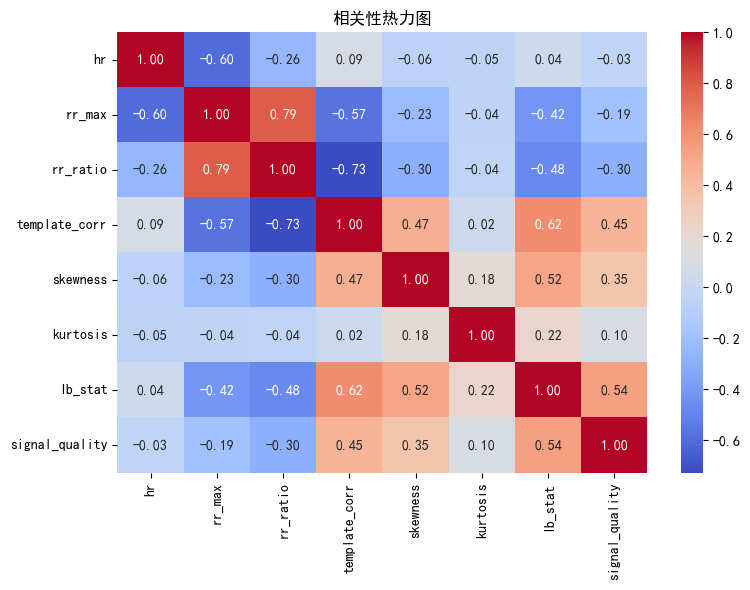

In [32]:
import seaborn as sns
corr_matrix = df[features + ["signal_quality"]].corr()

# 绘制相关性热力图
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("相关性热力图")
plt.tight_layout()
plt.show()

In [33]:
# 划分数据集训练集
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X = df[features]
y = df["signal_quality"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [34]:
# 训练 bagging 模型用于信号质量评估

from sklearn.ensemble import BaggingClassifier
bagging_clf = BaggingClassifier(n_estimators=50, random_state=42)
bagging_clf.fit(X_train, y_train)

# 测试集预测与评估
y_pred = bagging_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Bagging 测试集准确率: {acc:.3f}")
print(classification_report(y_test, y_pred))

Bagging 测试集准确率: 0.957
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97       937
         1.0       0.91      0.85      0.88       220

    accuracy                           0.96      1157
   macro avg       0.94      0.92      0.93      1157
weighted avg       0.96      0.96      0.96      1157

